In [1]:
suppressPackageStartupMessages({
    library(VariantAnnotation)
    library(tidyverse)
})

In [2]:
read_vcf <- function(path) {
    readVcf(path, param=ScanVcfParam(info=c("S", "DOM", "PO", "GO", "MT"), geno="GT"))
}

In [3]:
get_muts <- function(vcf, mut_type) {
    mut_pos <- info(vcf)$MT == mut_type
    gr <- granges(vcf)[mut_pos]

    gt_mat <- geno(vcf)$GT[mut_pos, ]

    ind_gts <- apply(gt_mat, 2, function(gt) { str_count(gt, "1") })
    mut_freqs <- apply(ind_gts, 1, sum) / (2 * ncol(ind_gts))

    info_cols <- as.data.frame(info(vcf)[mut_pos, c("S", "DOM", "PO", "GO")])

    mcols(gr) <- bind_cols(info_cols, as.data.frame(mut_freqs), as.data.frame(ind_gts))
    names(gr) <- NULL

    # shift VCF coordinates back to the SLiM 0-based system
    gr <- shift(gr, shift=-1)

    sort(gr)
}

In [4]:
read_regions <- function(region) {
    regions_bed <- paste0("../data/slim_coords/", region, "_regions.bed")
    gr <- read_tsv(regions_bed, col_types="ciicdiii") %>%
        makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE)
    gr
}

In [5]:
read_sites <- function(region) {
    sites_bed <- paste0("../data/slim_coords/", region, "_all_sites.bed")
    gr <- read_tsv(sites_bed, col_types="ciiii") %>%
        select(real_chrom=chrom, real_start=start, real_end=end, start=slim_start, end=slim_end) %>%
        mutate(chrom=1) %>% 
        makeGRangesFromDataFrame(keep.extra.columns=TRUE)
    gr
}

In [6]:
transpose_sites <- function(slim_sites, real_sites) {
    hits <- findOverlaps(slim_sites, real_sites)
    transposed <- as.data.frame(mcols(real_sites)) %>%
        setNames(c("chrom", "start", "end")) %>%
        makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE) %>%
        .[queryHits(hits)]
    mcols(transposed) <- mcols(slim_sites)

    transposed
}

In [7]:
nea_per_ind <- function(gr) {
    ind_counts <- as.data.frame(mcols(gr)) %>%
         select(starts_with("i")) %>%
         summarise_all(sum) %>%
         t %>%
         as.vector
    
    ind_counts / length(gr) / 2
}

In [8]:
read_regions <- function(region) {
    regions_bed <- paste0(region)
    gr <- read_tsv(regions_bed, col_types="ii") %>% setNames(c("start", "end")) %>% mutate(seqnames="1") %>% 
        makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE)
    gr
}

In [28]:
regions <- read_regions("../../slim-neanderthal/clean_data/exome_and_sites_exon_coordinates.txt")

In [10]:
gen <- 1
vcf <- read_vcf(paste0("../data/simulations/nea_vs_mh_0.5_gen_", gen, ".vcf"))
muts <- get_muts(vcf, mut_type=0)

In [11]:
nea_muts <- muts[muts$PO == 2]
mh_muts <- muts[muts$PO == 1 & muts$GO >= 50000]

In [12]:
nea_muts

GRanges object with 6390 ranges and 305 metadata columns:
         seqnames               ranges strand |            S       DOM
            <Rle>            <IRanges>  <Rle> |    <numeric> <numeric>
     [1]        1     [  9943,   9943]      * | -0.000348655       0.5
     [2]        1     [ 33261,  33261]      * | -0.000158007       0.5
     [3]        1     [ 35327,  35327]      * | -1.04114e-06       0.5
     [4]        1     [ 68001,  68001]      * | -7.24997e-05       0.5
     [5]        1     [103298, 103298]      * | -0.000483462       0.5
     ...      ...                  ...    ... .          ...       ...
  [6386]        1 [72579469, 72579469]      * | -0.000250053       0.5
  [6387]        1 [72591371, 72591371]      * |  -2.0128e-07       0.5
  [6388]        1 [72591527, 72591527]      * |   -0.0088922       0.5
  [6389]        1 [72619885, 72619885]      * |  -0.00111189       0.5
  [6390]        1 [72627331, 72627331]      * |  -0.00104399       0.5
                PO 

In [13]:
mh_muts

GRanges object with 44223 ranges and 305 metadata columns:
          seqnames               ranges strand |            S       DOM
             <Rle>            <IRanges>  <Rle> |    <numeric> <numeric>
      [1]        1         [ 412,  412]      * |  -2.3815e-05       0.5
      [2]        1         [1444, 1444]      * | -0.000371972       0.5
      [3]        1         [2022, 2022]      * |   -0.0018744       0.5
      [4]        1         [3321, 3321]      * | -2.14916e-06       0.5
      [5]        1         [6202, 6202]      * |   -0.0700929       0.5
      ...      ...                  ...    ... .          ...       ...
  [44219]        1 [72618736, 72618736]      * | -0.000405194       0.5
  [44220]        1 [72618922, 72618922]      * | -6.43147e-05       0.5
  [44221]        1 [72626257, 72626257]      * | -3.46737e-09       0.5
  [44222]        1 [72626581, 72626581]      * | -4.89721e-06       0.5
  [44223]        1 [72627252, 72627252]      * |  -0.00441941       0.5
     

In [14]:
muts <- mh_muts

In [15]:
hits <- findOverlaps(regions, muts)

In [16]:
hits

Hits object with 44106 hits and 0 metadata columns:
          queryHits subjectHits
          <integer>   <integer>
      [1]         1           1
      [2]         2           2
      [3]         3           3
      [4]         3           4
      [5]        17           5
      ...       ...         ...
  [44102]    214174       44219
  [44103]    214174       44220
  [44104]    214187       44221
  [44105]    214187       44222
  [44106]    214187       44223
  -------
  queryLength: 214193 / subjectLength: 44223

In [127]:
unique(queryHits(hits))

[1]      1      2      3     17     49     63     69     73     74     76
   [11]     79     80     89    122    123    125    142    156    177    185
   [21]    186    194    195    196    198    211    216    227    238    246
   [31]    249    260    262    265    268    270    271    272    283    297
   [41]    300    309    314    317    325    326    337    342    350    370
   [51]    374    378    381    383    404    447    469    477    482    487
   [61]    495    513    523    532    543    545    547    548    566    579
   [71]    590    592    601    602    605    606    608    619    623    628
   [81]    633    635    636    638    649    657    660    664    681    682
   [91]    684    708    713    729    740    749    752    757    763    766
  [101]    777    799    817    822    830    835    844    852    855    865
  [111]    866    867    873    879    881    899    900    905    910    913
  [121]    919    965    966    967    982    990    994    997   1009   1029
  [131]   1033   1042   1043   1047   1060   1064   1082   1092   1104   1113
  [141]   1120   1137   1148   1149   1152   1161   1162   1163   1192   1196
  [151]   1199   1207   1215   1235   1241   1243   1260   1261   1270   1273
  [161]   1278   1283   1292   1299   1302   1310   1323   1337   1345   1355
  [171]   1358   1361   1364   1367   1376   1385   1387   1389   1400   1412
  [181]   1414   1425   1426   1433   1443   1455   1456   1463   1464   1472
  [191]   1480   1489   1501   1506   1514   1515   1539   1541   1542   1546
  [201]   1556   1563   1564   1578   1579   1595   1602   1634   1654   1689
  [211]   1698   1703   1721   1728   1729   1733   1746   1760   1769   1778
  [221]   1779   1787   1797   1799   1802   1812   1815   1824   1828   1843
  [231]   1847   1855   1856   1857   1858   1898   1911   1923   1924   1934
  [241]   1953   1955   1964   1973   1987   1988   2018   2022   2026   2037
  [251]   2044   2045   2047   2049   2058   2064   2065   2067   2073   2078
  [261]   2079   2081   2085   2086   2088   2095   2099   2101   2105   2106
  [271]   2112   2114   2121   2122   2130   2132   2148   2155   2162   2167
  [281]   2170   2196   2202   2206   2208   2211   2212   2218   2219   2236
  [291]   2240   2258   2260   2267   2273   2277   2278   2297   2302   2308
  [301]   2318   2320   2332   2336   2353   2354   2371   2373   2375   2386
  [311]   2391   2400   2408   2433   2444   2447   2449   2462   2475   2487
  [321]   2489   2491   2510   2512   2522   2531   2542   2563   2569   2577
  [331]   2603   2608   2613   2635   2637   2663   2675   2682   2684   2686
  [341]   2687   2710   2734   2736   2743   2745   2748   2749   2750   2761
  [351]   2764   2765   2766   2774   2779   2790   2796   2804   2816   2839
  [361]   2853   2854   2856   2864   2869   2882   2912   2922   2924   2925
  [371]   2927   2937   2945   2958   2962   2970   2971   2973   2974   2978
  [381]   2991   2999   3015   3021   3022   3023   3024   3029   3043   3048
  [391]   3051   3057   3061   3062   3073   3075   3085   3088   3091   3092
  [401]   3095   3099   3100   3110   3122   3123   3126   3151   3156   3157
  [411]   3172   3184   3201   3230   3236   3243   3277   3284   3291   3294
  [421]   3313   3320   3325   3330   3333   3339   3343   3362   3371   3384
  [431]   3396   3398   3402   3408   3412   3414   3416   3417   3421   3424
  [441]   3426   3428   3434   3441   3444   3449   3454   3458   3469   3476
  [451]   3487   3488   3494   3511   3518   3519   3520   3521   3528   3529
  [461]   3540   3551   3561   3583   3584   3590   3595   3598   3601   3604
  [471]   3616   3618   3631   3634   3638   3643   3650   3664   3671   3672
  [481]   3673   3674   3689   3693   3701   3718   3719   3720   3723   3725
  [491]   3731   3752   3757   3760   3771   3776   3777   3778   3783   3787
  [501]   3796   3797   3799   3808   3809   3815   3824   3833   3835   3836
  [511]   3837   3854   38

In [17]:
regions[queryHits(hits)]

GRanges object with 44106 ranges and 0 metadata columns:
          seqnames               ranges strand
             <Rle>            <IRanges>  <Rle>
      [1]        1         [   1,  917]      *
      [2]        1         [ 920, 1820]      *
      [3]        1         [1823, 3580]      *
      [4]        1         [1823, 3580]      *
      [5]        1         [6094, 6277]      *
      ...      ...                  ...    ...
  [44102]        1 [72617778, 72620030]      *
  [44103]        1 [72617778, 72620030]      *
  [44104]        1 [72625918, 72627816]      *
  [44105]        1 [72625918, 72627816]      *
  [44106]        1 [72625918, 72627816]      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

In [18]:
muts[subjectHits(hits)]

GRanges object with 44106 ranges and 305 metadata columns:
          seqnames               ranges strand |            S       DOM
             <Rle>            <IRanges>  <Rle> |    <numeric> <numeric>
      [1]        1         [ 412,  412]      * |  -2.3815e-05       0.5
      [2]        1         [1444, 1444]      * | -0.000371972       0.5
      [3]        1         [2022, 2022]      * |   -0.0018744       0.5
      [4]        1         [3321, 3321]      * | -2.14916e-06       0.5
      [5]        1         [6202, 6202]      * |   -0.0700929       0.5
      ...      ...                  ...    ... .          ...       ...
  [44102]        1 [72618736, 72618736]      * | -0.000405194       0.5
  [44103]        1 [72618922, 72618922]      * | -6.43147e-05       0.5
  [44104]        1 [72626257, 72626257]      * | -3.46737e-09       0.5
  [44105]        1 [72626581, 72626581]      * | -4.89721e-06       0.5
  [44106]        1 [72627252, 72627252]      * |  -0.00441941       0.5
     

In [29]:
muts <- muts[subjectHits(hits)]

In [33]:
muts$region_id <- queryHits(hits)

Save the information about mutations (s, h) into a separate df:

In [84]:
(mut_info <- as.data.frame(mcols(muts)) %>% select(S, DOM)) %>% tail

S            DOM
44101 -5.58249e-05 0.5
44102 -4.05194e-04 0.5
44103 -6.43147e-05 0.5
44104 -3.46737e-09 0.5
44105 -4.89721e-06 0.5
44106 -4.41941e-03 0.5

In [99]:
as.data.frame(mcols(muts)) %>% select(region_id, starts_with("i")) %>% tail

region_id i0 i1 i2 i3 i4 i5 i6 i7 i8 ⋯ i290 i291 i292 i293 i294 i295 i296
44101 214163    0  0  1  1  0  0  1  0  1  ⋯ 2    0    1    1    1    0    1   
44102 214174    0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    0    0    0    0   
44103 214174    0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    0    0    0    0   
44104 214187    0  0  1  1  1  0  1  1  2  ⋯ 1    0    1    0    2    0    1   
44105 214187    0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    0    0    0    0   
44106 214187    0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    1    0    0    0   
      i297 i298 i299
44101 0    1    1   
44102 0    0    0   
44103 0    0    0   
44104 0    1    2   
44105 0    0    0   
44106 0    0    0

In [124]:
region_loads <- as.data.frame(mcols(muts)) %>%
    mutate_at(vars(starts_with("i")), funs(ifelse(. == 0, 0, ifelse(. == 1, mut_info$DOM, 1)) * mut_info$S)) %>%
    group_by(region_id) %>%
    summarise_at(vars(starts_with("i")), sum) %>%
    select(-region_id) %>%
    as.matrix %>%
    {1 - exp(.)}

In [125]:
nrow(region_loads)

[1] 29815

In [17]:
gens <- c(1, 2, 3, 4, 5, 10, 25, 50, 100, 200)

for (gen in gens) {
    vcf <- read_vcf(paste0("../data/simulations/nea_vs_mh_0.5_gen_", gen, ".vcf"))
    del_muts <- get_allele_counts(vcf, mut_type=0)
    
    nea_muts <- muts[muts$PO == 2]
    mh_muts <- muts[muts$PO == 1 & muts$GO >= 50000]
    
    mcols(regions)[[paste0("nea_", gen)]] <- muts_per_region(regions, nea_per_ind)
    mcols(regions)[[paste0("mh_", gen)]] <- muts_per_region(regions, mh_per_ind)
    
    cat(gen, "\n")
}

1 


In [36]:
summary(regions$mh / regions$nea)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0     Inf     Inf     Inf     Inf     Inf  181289 

In [30]:
head(regions)

GRanges object with 6 ranges and 2 metadata columns:
      seqnames       ranges strand |       nea        mh
         <Rle>    <IRanges>  <Rle> | <numeric> <numeric>
  [1]        1 [   1,  917]      * |         0         1
  [2]        1 [ 920, 1820]      * |         0         1
  [3]        1 [1823, 3580]      * |         0         2
  [4]        1 [3583, 4576]      * |         0         0
  [5]        1 [4579, 5572]      * |         0         0
  [6]        1 [5575, 5660]      * |         0         0
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

In [28]:
x <- regions
x$nea <- x$nea / (width(x) / 1e3)
x$mh <- x$mh / (width(x) / 1e3)

In [34]:
summary(x$mh)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
  0.0000   0.0000   0.0000   0.6129   0.0000 333.3333       12 

In [366]:
vcf <- read_vcf("../data/simulations/nea_vs_mh_0.5_gen_100.vcf")
muts_per_ind <- get_allele_counts(vcf, mut_type=0)

In [367]:
regions <- read_regions("../../slim-neanderthal/clean_data/exome_and_sites_exon_coordinates.txt")

In [368]:
regions

GRanges object with 214193 ranges and 0 metadata columns:
           seqnames               ranges strand
              <Rle>            <IRanges>  <Rle>
       [1]        1         [   1,  917]      *
       [2]        1         [ 920, 1820]      *
       [3]        1         [1823, 3580]      *
       [4]        1         [3583, 4576]      *
       [5]        1         [4579, 5572]      *
       ...      ...                  ...    ...
  [214189]        1 [72627900, 72627978]      *
  [214190]        1 [72627981, 72628009]      *
  [214191]        1 [72628012, 72628174]      *
  [214192]        1 [72628177, 72628693]      *
  [214193]        1 [72628696, 72628857]      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

In [369]:
nea_per_ind <- muts_per_ind[muts_per_ind$PO == 2]
mh_per_ind <- muts_per_ind[muts_per_ind$PO == 1 & muts_per_ind$GO >= 50000]

In [370]:
regions$nea <- muts_per_region(regions, nea_per_ind)
regions$mh <- muts_per_region(regions, mh_per_ind)

In [371]:
reg_with_muts <- regions[regions$nea > 0 | regions$mh > 0]

In [372]:
reg_with_muts

GRanges object with 25858 ranges and 2 metadata columns:
          seqnames               ranges strand |       nea        mh
             <Rle>            <IRanges>  <Rle> | <numeric> <numeric>
      [1]        1       [  920,  1820]      * |         0         1
      [2]        1       [ 1823,  3580]      * |         0         2
      [3]        1       [14069, 14388]      * |         0         1
      [4]        1       [14972, 15111]      * |         0         1
      [5]        1       [15526, 16191]      * |         0         1
      ...      ...                  ...    ... .       ...       ...
  [25854]        1 [72615098, 72615386]      * |         0         1
  [25855]        1 [72616689, 72616884]      * |         0         1
  [25856]        1 [72617778, 72620030]      * |         1         2
  [25857]        1 [72625918, 72627816]      * |         1         2
  [25858]        1 [72628177, 72628693]      * |         0         1
  -------
  seqinfo: 1 sequence from an unspec

In [373]:
mean(reg_with_muts$mh) / mean(reg_with_muts$nea)

[1] 8.124409

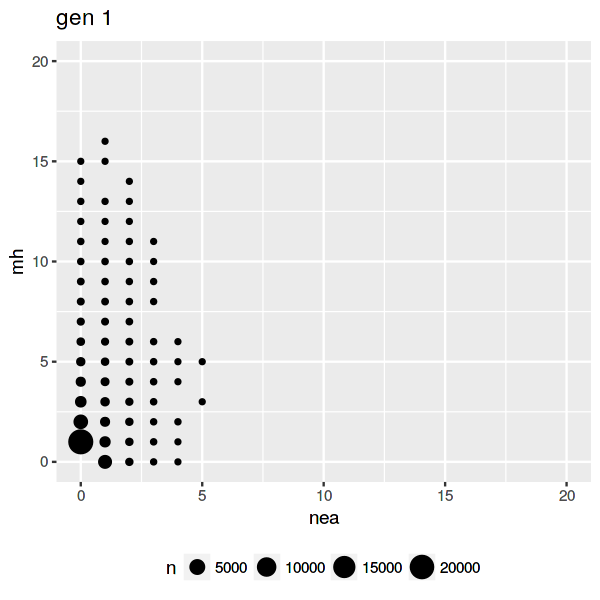

In [356]:
options(repr.plot.width=5, repr.plot.height=5)

as.data.frame(reg_with_muts) %>% select(nea, mh) %>%
ggplot(aes(nea, mh)) + geom_count() + xlim(0, 20) + ylim(0, 20) + theme(legend.position="bottom") + ggtitle("gen 1")

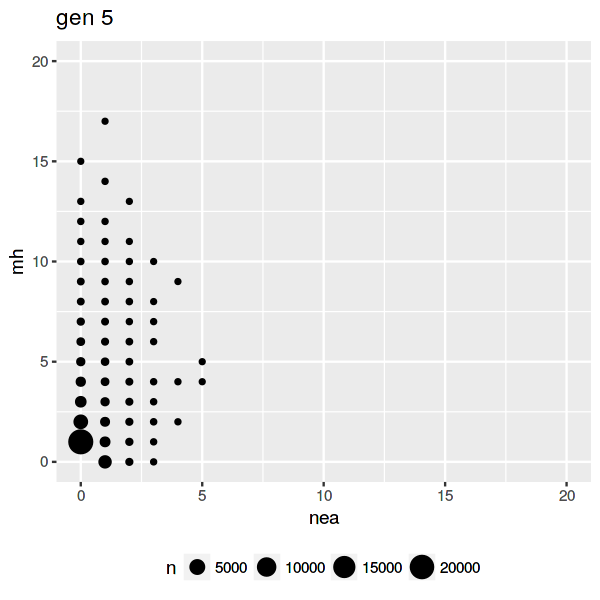

In [365]:
options(repr.plot.width=5, repr.plot.height=5)

as.data.frame(reg_with_muts) %>% select(nea, mh) %>%
ggplot(aes(nea, mh)) + geom_count() + xlim(0, 20) + ylim(0, 20) + theme(legend.position="bottom") + ggtitle("gen 5")

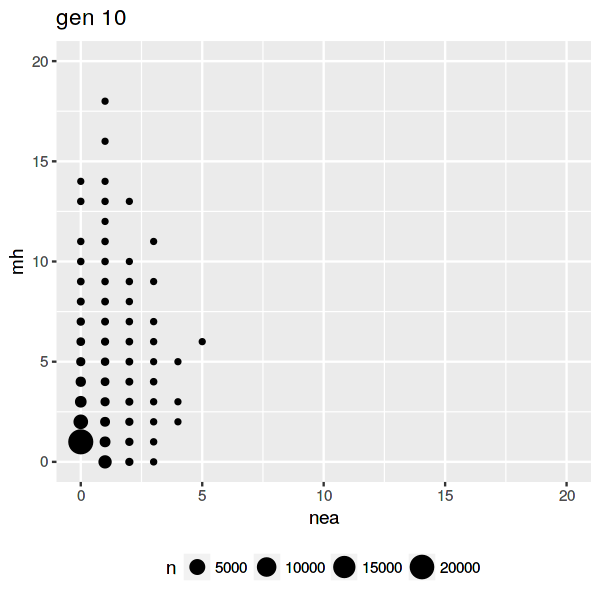

In [337]:
options(repr.plot.width=5, repr.plot.height=5)

as.data.frame(reg_with_muts) %>% select(nea, mh) %>%
ggplot(aes(nea, mh)) + geom_count() + xlim(0, 20) + ylim(0, 20) + theme(legend.position="bottom") + ggtitle("gen 10")

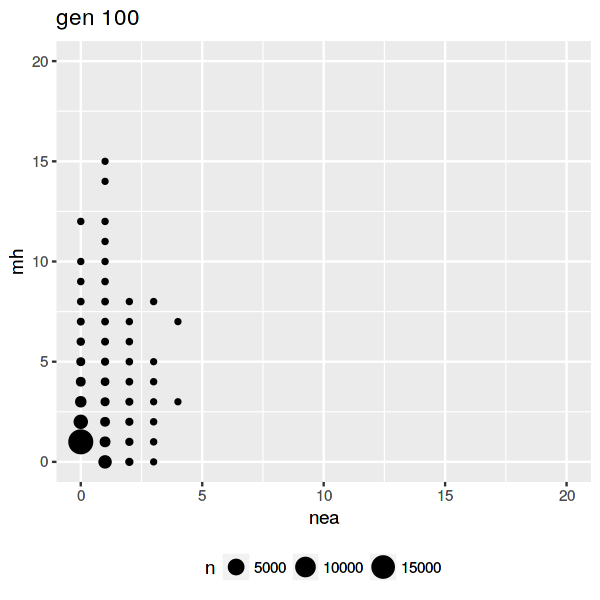

In [374]:
options(repr.plot.width=5, repr.plot.height=5)

as.data.frame(reg_with_muts) %>% select(nea, mh) %>%
ggplot(aes(nea, mh)) + geom_count() + xlim(0, 20) + ylim(0, 20) + theme(legend.position="bottom") + ggtitle("gen 100")

In [299]:
vcf_path <- "../data/simulations/promoter_h_0.5_rep_1_gen_1.vcf.gz"
region <- "promoter"

In [220]:
gap_vs_func_nea <- function(vcf_path, region) {
    vcf <- read_vcf(vcf_path)
    slim_sites <- get_allele_counts(vcf, mut_type=1)
    real_sites <- read_sites("promoter")
    
    markers <- transpose_sites(slim_sites, real_sites)

    regions <- read_regions(region)
    
    region_markers <- subsetByOverlaps(markers, regions)
    gap_markers <- subsetByOverlaps(markers, regions, invert=TRUE)
    
    bind_rows(
        tibble(region="gap", nea=nea_per_ind(gap_markers)),
        tibble(region=region, nea=nea_per_ind(region_markers))
    )          
}

In [233]:
nea_h <- lapply(c("0.0", "0.5", "1.0"), function(h) {
    gap_vs_func_nea(paste0("../data/simulations/promoter_h_", h, "_rep_1_gen_2200.vcf.gz"), "promoter") %>% mutate(h=h)
}) %>% bind_rows

In [257]:
options(repr.plot.width=8, repr.plot.height=3, repr.plot.res=300)

ggplot(nea_h, aes(region, nea, fill=region)) + geom_boxplot(outlier.shape=NA) + geom_jitter(alpha=1/2, size=0.5) + facet_grid(. ~ h)

In [290]:
df_h <- lapply(c("promoter", "protein_coding", "tf_binding_site"), function(r) {
lapply(c("0.0", "0.5", "1.0"), function(h) {
    files <- list.files(path="../data/simulations/", pattern=paste0(r, "_h_", h, "_rep_.*trajectory.*"), full.names=TRUE)
    lapply(files, function(f) {
        suppressMessages(read_tsv(f) %>% mutate(rep=f, h=h, reg=r))
    }) %>% bind_rows
}) %>%
    bind_rows %>% 
    group_by(h, gen, reg) %>% summarise(nea_mean=mean(mean), nea_sd=mean(sd)) %>%
    ungroup
}) %>% bind_rows

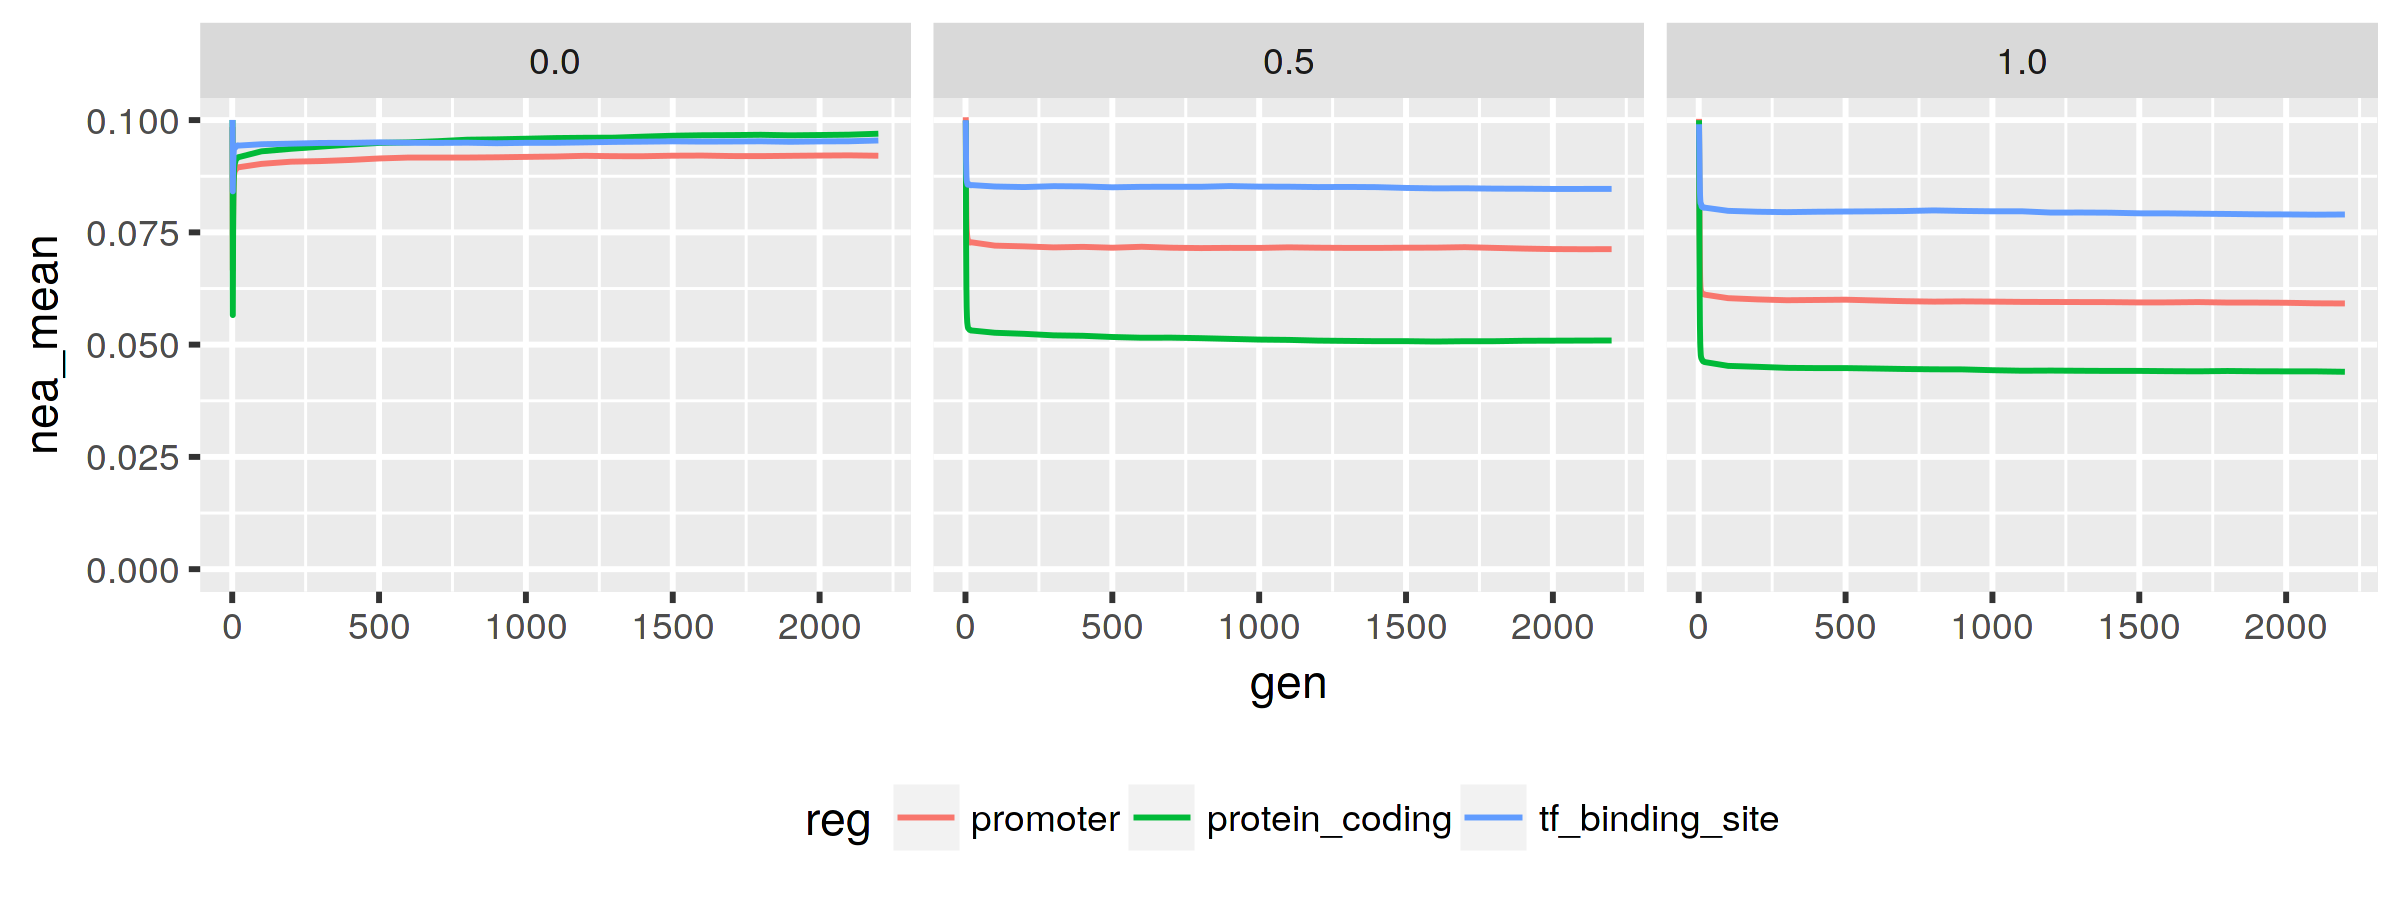

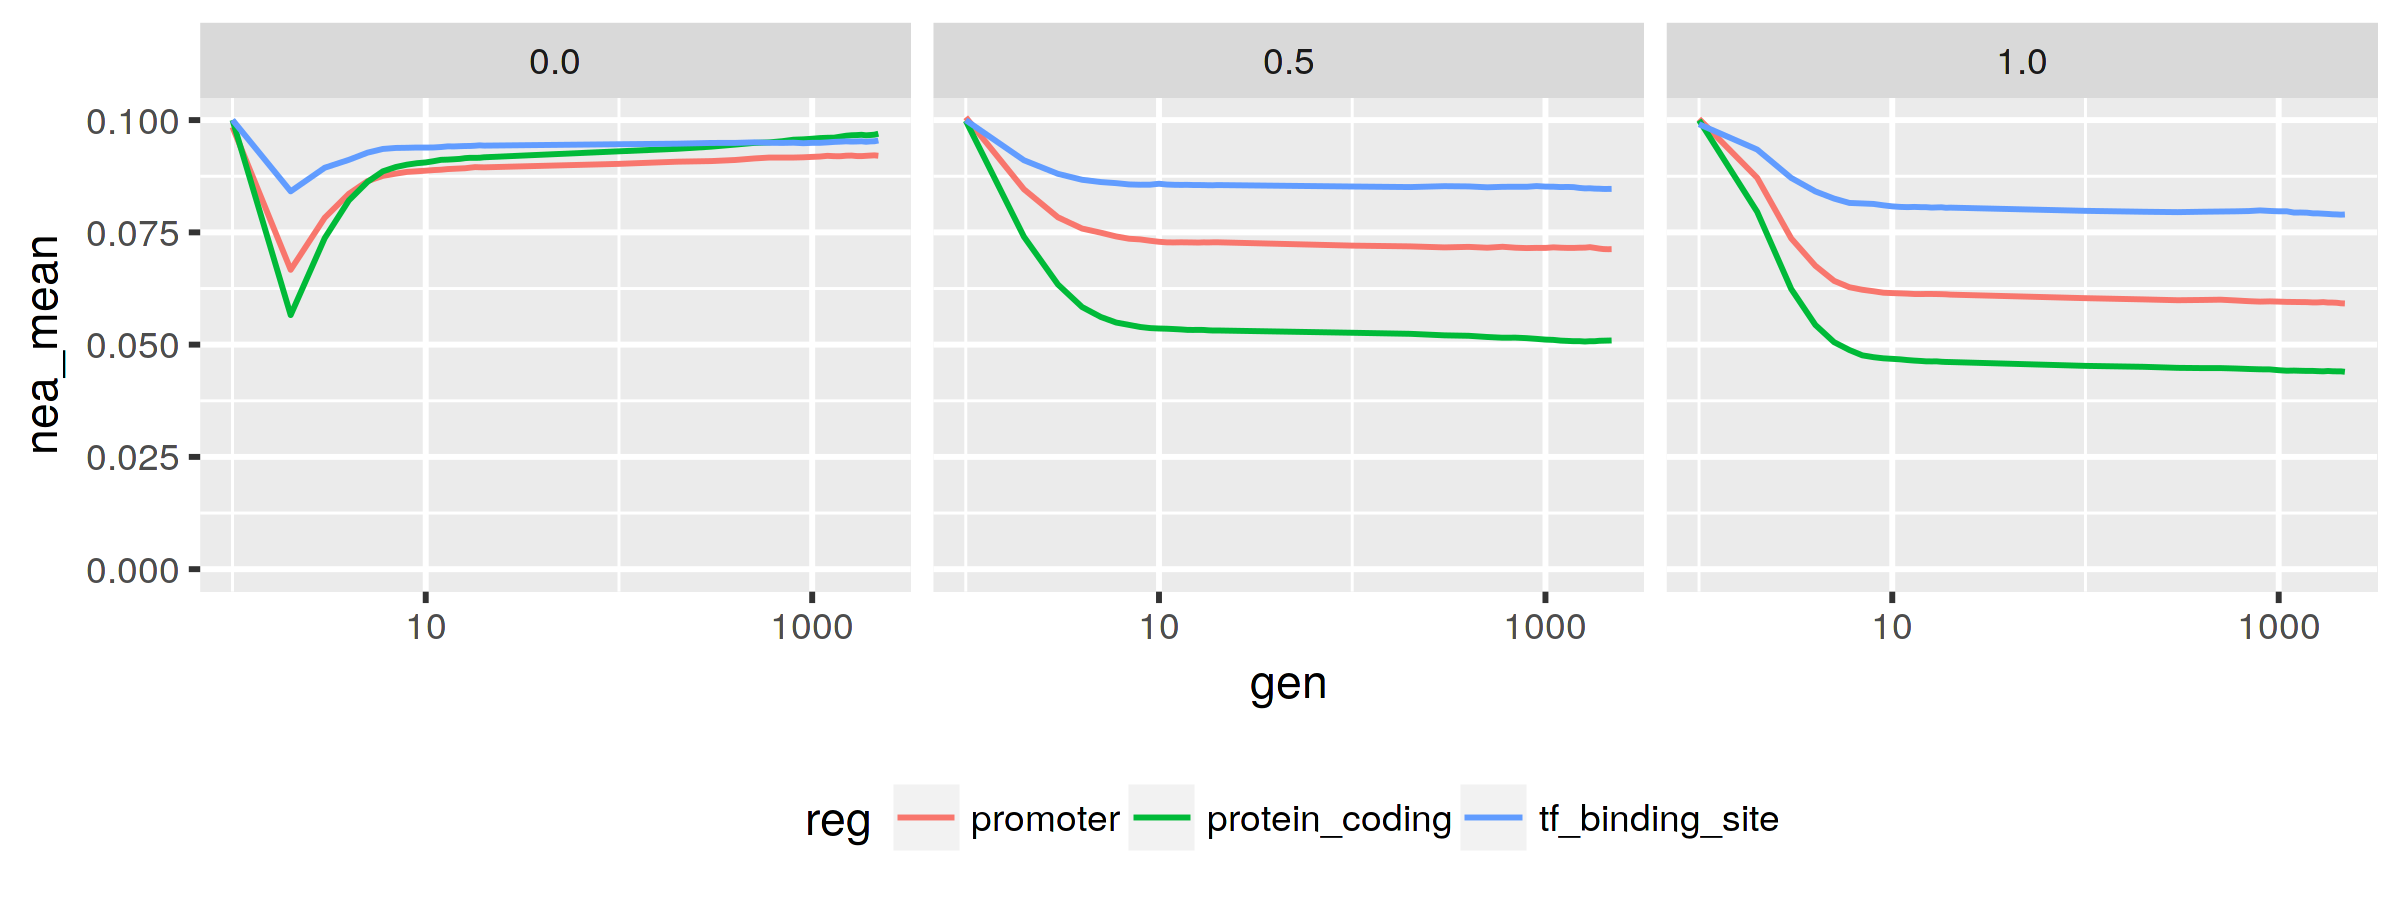

In [291]:
options(repr.plot.width=8, repr.plot.height=3, repr.plot.res=300)

ggplot(df_h, aes(gen, nea_mean)) + geom_line(aes(color=reg)) + facet_grid(. ~ h) + coord_cartesian(y=c(0, 0.1)) + theme(legend.position="bottom")
ggplot(df_h, aes(gen, nea_mean)) + geom_line(aes(color=reg)) + facet_grid(. ~ h) + coord_cartesian(y=c(0, 0.1)) + theme(legend.position="bottom") + scale_x_log10()

In [326]:
x <- function(vcf_path) {
    vcf <- read_vcf(vcf_path)
    
    region_markers <- get_allele_counts(vcf, mut_type=1)
    gap_markers <- get_allele_counts(vcf, mut_type=2)
    
    bind_rows(
        tibble(region="gap", nea=nea_per_ind(gap_markers)),
        tibble(region="exon", nea=nea_per_ind(region_markers))
    )          
}

In [332]:
a <- lapply(c("0.0", "0.5", "1.0"), function(h) {
    x(paste0("../data/simulations/old_", h, ".vcf")) %>% mutate(h=h)
}) %>% bind_rows

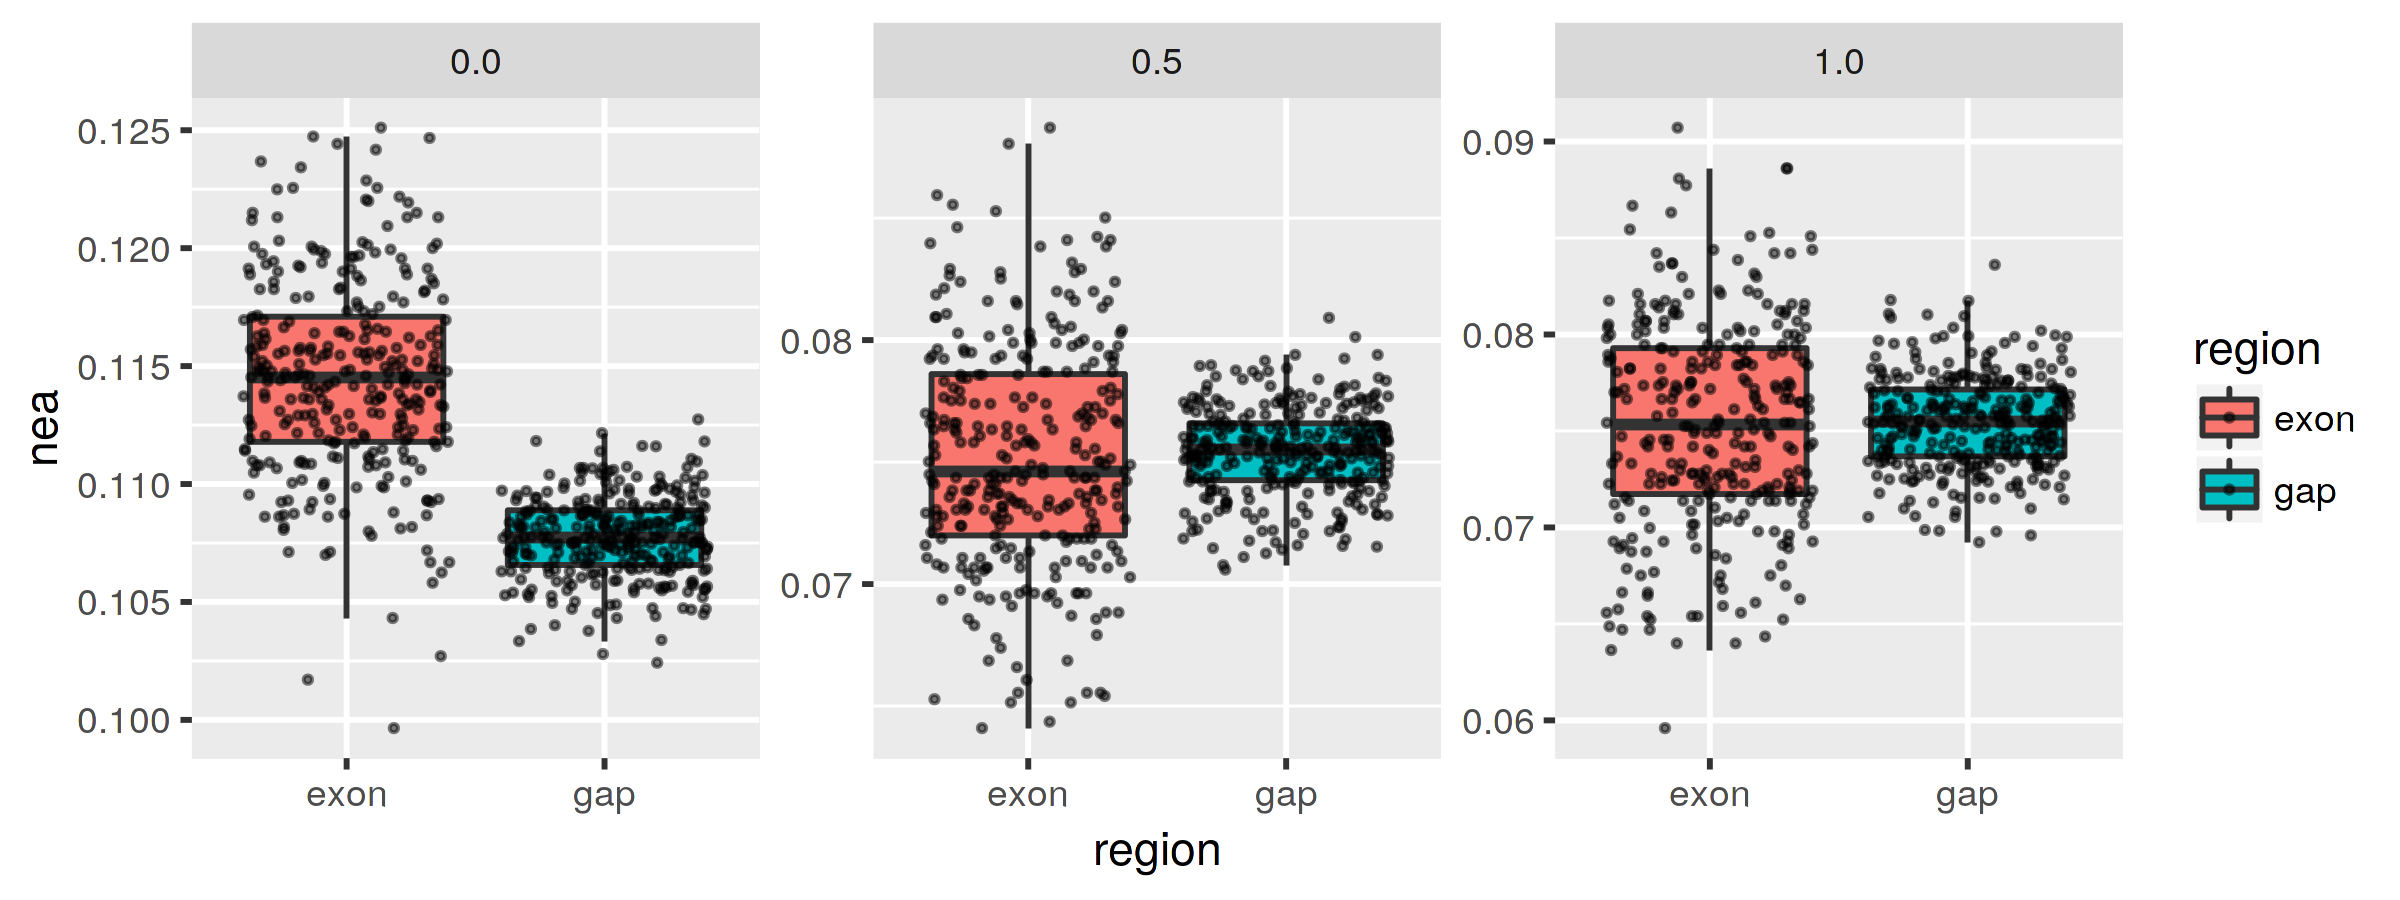

In [337]:
options(repr.plot.width=8, repr.plot.height=3, repr.plot.res=300)

ggplot(a, aes(region, nea, fill=region)) + geom_boxplot(outlier.shape=NA) + geom_jitter(alpha=1/2, size=0.5) +
    facet_wrap(~ h, scales="free_y")

In [223]:
for (f in list.files("../data/simulations", "promoter_h_0.5_rep_1_gen_*.*vcf", full.names=TRUE)) {
    vcf <- read_vcf(f)
    marker_counts <- get_allele_counts(vcf, mut_type=1)
    cat(f, "\t", mean(nea_per_ind(marker_counts)), "\n")
}

../data/simulations/promoter_h_0.5_rep_1_gen_1.vcf.gz 	 0.09 
../data/simulations/promoter_h_0.5_rep_1_gen_10.vcf.gz 	 0.06809177 
../data/simulations/promoter_h_0.5_rep_1_gen_100.vcf.gz 	 0.066536 
../data/simulations/promoter_h_0.5_rep_1_gen_1500.vcf.gz 	 0.08449581 
../data/simulations/promoter_h_0.5_rep_1_gen_2200.vcf.gz 	 0.09826743 
../data/simulations/promoter_h_0.5_rep_1_gen_5.vcf.gz 	 0.05865214 
../data/simulations/promoter_h_0.5_rep_1_gen_500.vcf.gz 	 0.06753049 


In [224]:
for (f in list.files("../data/simulations", "promoter_h_0.0_rep_1_gen_*.*vcf", full.names=TRUE)) {
    vcf <- read_vcf(f)
    marker_counts <- get_allele_counts(vcf, mut_type=1)
    cat(f, "\t", mean(nea_per_ind(marker_counts)), "\n")
}

../data/simulations/promoter_h_0.0_rep_1_gen_1.vcf.gz 	 0.06 
../data/simulations/promoter_h_0.0_rep_1_gen_10.vcf.gz 	 0.09561368 
../data/simulations/promoter_h_0.0_rep_1_gen_100.vcf.gz 	 0.09832856 
../data/simulations/promoter_h_0.0_rep_1_gen_1500.vcf.gz 	 0.1084344 
../data/simulations/promoter_h_0.0_rep_1_gen_2200.vcf.gz 	 0.1204241 
../data/simulations/promoter_h_0.0_rep_1_gen_5.vcf.gz 	 0.1001793 
../data/simulations/promoter_h_0.0_rep_1_gen_500.vcf.gz 	 0.09818418 


In [179]:
regions <- read_regions("promoter")

In [180]:
sites <- read_sites("promoter")

In [187]:
transpose_sites(markers, sites)

GRanges object with 55168 ranges and 104 metadata columns:
          seqnames               ranges strand |         S       DOM        PO
             <Rle>            <IRanges>  <Rle> | <numeric> <numeric> <integer>
      [1]     chr1   [1119546, 1119546]      * |         0       0.5         2
      [2]     chr1   [1696390, 1696390]      * |         0       0.5         2
      [3]     chr1   [1707669, 1707669]      * |         0       0.5         2
      [4]     chr1   [1710633, 1710633]      * |         0       0.5         2
      [5]     chr1   [1749357, 1749357]      * |         0       0.5         2
      ...      ...                  ...    ... .       ...       ...       ...
  [55164]    chr22 [50666507, 50666507]      * |         0       0.5         2
  [55165]    chr22 [50677479, 50677479]      * |         0       0.5         2
  [55166]    chr22 [50683395, 50683395]      * |         0       0.5         2
  [55167]    chr22 [50683418, 50683418]      * |         0       0.5    

In [45]:
region_markers <- subsetByOverlaps(markers, regions)
gap_markers <- subsetByOverlaps(markers, regions, invert=TRUE)

In [53]:
nea_per_ind(region_markers)
nea_per_ind(gap_markers)

[1] TRUE

In [62]:
calc_trajectories <- function(prefix, fn) {
    for (f in Sys.glob(paste0(prefix, "*.vcf"))) {
        vcf <- read_vcf(f)
        marker_counts <- get_allele_counts(vcf, type=1)
    }
}

In [63]:
calc_trajectories("../data/simulations/promoter_h_0.5_rep_1_gen_")

../data/simulations/promoter_h_0.5_rep_1_gen_100.vcf ../data/simulations/promoter_h_0.5_rep_1_gen_10.vcf ../data/simulations/promoter_h_0.5_rep_1_gen_1.vcf ../data/simulations/promoter_h_0.5_rep_1_gen_500.vcf ../data/simulations/promoter_h_0.5_rep_1_gen_5.vcf